=== Time Series Momentum (TSMOM) Strategy Implementation ===
Based on 'A Century of Evidence on Trend-Following Investing' by Hurst et al.

Creating sample data for demonstration...
Note: In practice, you should use real futures price data
Data period: 2010-01-01 to 2023-12-31
Number of assets: 13
Assets: ['Crude_Oil', 'Gold', 'Copper', 'Wheat', 'EUR_USD', 'GBP_USD', 'JPY_USD', 'SP500', 'FTSE', 'DAX', 'US_10Y', 'DE_10Y', 'UK_10Y']

Running TSMOM strategy...
Calculating excess returns...
Calculating volatility estimates...
Running 1-month TSMOM strategy...
Running 3-month TSMOM strategy...
Running 12-month TSMOM strategy...
Creating diversified portfolio...

=== Performance Summary ===

TSMOM_1M:
  Annual Return: 2496.2%
  Annual Volatility: 158.0%
  Sharpe Ratio: 15.80
  Max Drawdown: -54.4%

TSMOM_3M:
  Annual Return: 1768.2%
  Annual Volatility: 163.5%
  Sharpe Ratio: 10.81
  Max Drawdown: -91.0%

TSMOM_12M:
  Annual Return: 845.9%
  Annual Volatility: 152.4%
  Sharpe Ratio: 5.55
  M

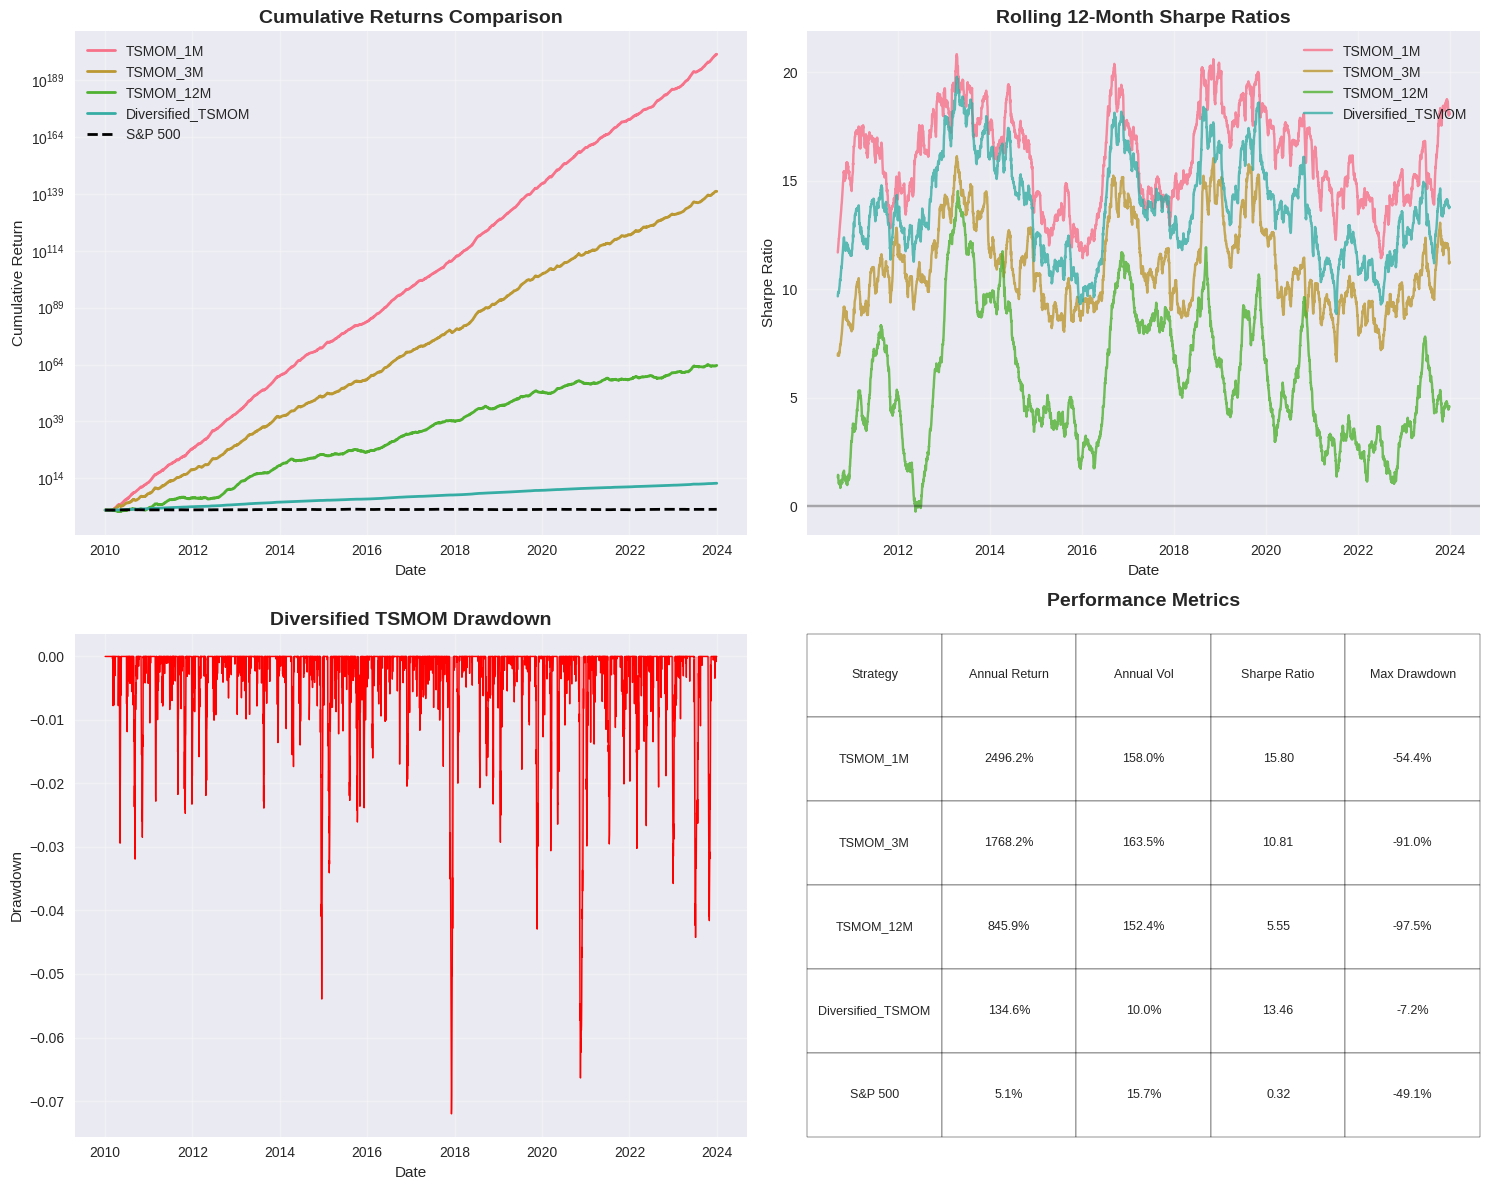

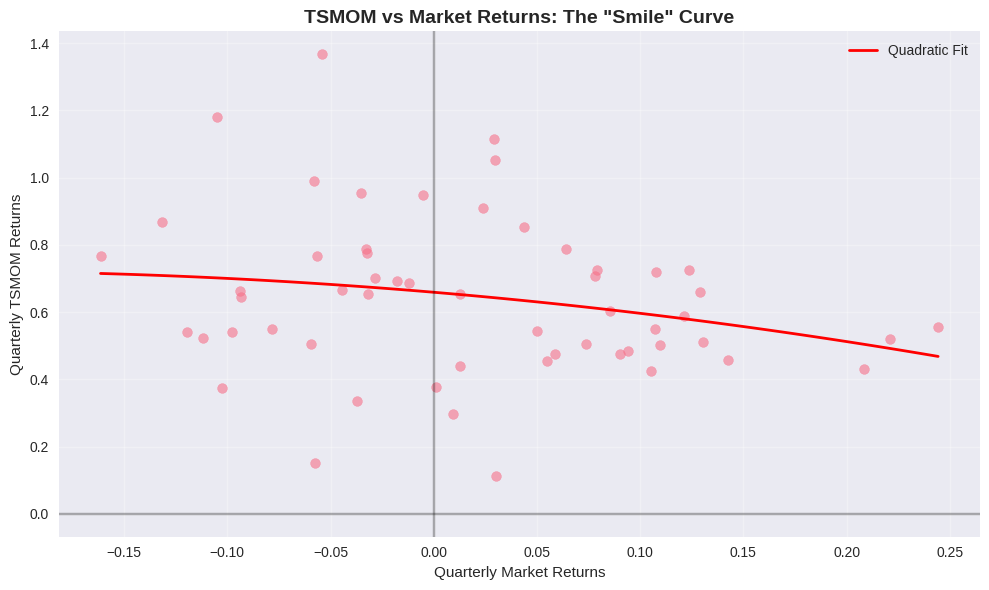


=== Strategy Implementation Complete ===
Note: This is a demonstration using simulated data.
For live trading, use real futures price data and consider:
- Transaction costs (1-4% annually)
- Management fees (typically 2% + 20% performance fee)
- Margin requirements (8-12% for institutional investors)
- Risk management procedures
- Rebalancing frequency optimization


In [1]:
# Time Series Momentum (TSMOM) Strategy Implementation
# Based on "A Century of Evidence on Trend-Following Investing" by Hurst et al.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class TSMOMStrategy:
    """
    Time Series Momentum Strategy Implementation

    This class implements the TSMOM strategy as described in Hurst et al. (2013)
    using simple trend-following rules across multiple assets and time horizons.
    """

    def __init__(self, lookback_periods=[1, 3, 12], target_vol=0.40, portfolio_vol=0.10):
        """
        Initialize TSMOM Strategy

        Parameters:
        -----------
        lookback_periods : list, default [1, 3, 12]
            Lookback periods in months for trend signals
        target_vol : float, default 0.40
            Target volatility for individual assets (40%)
        portfolio_vol : float, default 0.10
            Target volatility for diversified portfolio (10%)
        """
        self.lookback_periods = lookback_periods
        self.target_vol = target_vol
        self.portfolio_vol = portfolio_vol
        self.delta = self._calculate_delta()  # For 60-day center of mass

    def _calculate_delta(self, center_of_mass=60):
        """Calculate delta parameter for exponential weighting (60-day center of mass)"""
        return 1 - 1/(center_of_mass + 1)

    def calculate_excess_returns(self, prices, risk_free_rate=0.02):
        """
        Calculate excess returns for each asset

        Parameters:
        -----------
        prices : pd.DataFrame
            Price data with datetime index and asset columns
        risk_free_rate : float, default 0.02
            Annual risk-free rate (2%)

        Returns:
        --------
        pd.DataFrame : Excess returns
        """
        # Calculate simple returns
        returns = prices.pct_change().dropna()

        # Convert annual risk-free rate to daily
        daily_rf = (1 + risk_free_rate) ** (1/252) - 1

        # Calculate excess returns
        excess_returns = returns - daily_rf

        return excess_returns

    def calculate_volatility(self, returns):
        """
        Calculate exponentially weighted volatility for each asset

        Parameters:
        -----------
        returns : pd.DataFrame
            Excess returns data

        Returns:
        --------
        pd.DataFrame : Annualized volatility estimates
        """
        # Initialize volatility DataFrame
        volatility = pd.DataFrame(index=returns.index, columns=returns.columns)

        for asset in returns.columns:
            asset_returns = returns[asset].dropna()
            vol_series = []

            # Calculate exponentially weighted variance
            for i in range(len(asset_returns)):
                if i < 60:  # Need at least 60 observations
                    vol_series.append(np.nan)
                else:
                    # Get recent returns
                    recent_returns = asset_returns.iloc[max(0, i-252):i+1]  # Last year of data

                    # Calculate exponentially weighted variance
                    weights = [(1-self.delta) * (self.delta**j) for j in range(len(recent_returns))]
                    weights = weights[::-1]  # Reverse to give more weight to recent observations
                    weights = np.array(weights) / sum(weights)  # Normalize

                    # Calculate mean return
                    mean_return = np.average(recent_returns, weights=weights)

                    # Calculate variance
                    variance = np.average((recent_returns - mean_return)**2, weights=weights)

                    # Annualize volatility (252 trading days)
                    annual_vol = np.sqrt(variance * 252)
                    vol_series.append(annual_vol)

            volatility[asset] = vol_series

        return volatility

    def generate_signals(self, excess_returns, lookback_months):
        """
        Generate trend-following signals based on past excess returns

        Parameters:
        -----------
        excess_returns : pd.DataFrame
            Excess returns data
        lookback_months : int
            Lookback period in months

        Returns:
        --------
        pd.DataFrame : Trading signals (+1 for long, -1 for short)
        """
        # Convert monthly lookback to daily (approximately 21 trading days per month)
        lookback_days = lookback_months * 21

        # Calculate cumulative excess returns over lookback period
        cumulative_returns = excess_returns.rolling(window=lookback_days).sum()

        # Generate signals: +1 if cumulative return > 0, -1 if < 0
        signals = np.where(cumulative_returns > 0, 1, -1)
        signals = pd.DataFrame(signals, index=excess_returns.index, columns=excess_returns.columns)

        return signals

    def calculate_position_sizes(self, signals, volatility):
        """
        Calculate position sizes based on constant volatility methodology

        Parameters:
        -----------
        signals : pd.DataFrame
            Trading signals
        volatility : pd.DataFrame
            Asset volatility estimates

        Returns:
        --------
        pd.DataFrame : Position sizes (as fraction of portfolio)
        """
        # Position size = target_vol / asset_volatility * signal
        position_sizes = signals * (self.target_vol / volatility)

        # Handle infinite values (when volatility is very small)
        position_sizes = position_sizes.replace([np.inf, -np.inf], 0)
        position_sizes = position_sizes.fillna(0)

        return position_sizes

    def calculate_strategy_returns(self, excess_returns, position_sizes):
        """
        Calculate strategy returns given position sizes

        Parameters:
        -----------
        excess_returns : pd.DataFrame
            Excess returns data
        position_sizes : pd.DataFrame
            Position sizes for each asset

        Returns:
        --------
        pd.Series : Strategy returns
        """
        # Lag position sizes by 1 day (use yesterday's positions for today's returns)
        lagged_positions = position_sizes.shift(1)

        # Calculate individual asset contributions
        asset_returns = excess_returns * lagged_positions

        # Sum across assets to get total strategy return
        strategy_returns = asset_returns.sum(axis=1)

        return strategy_returns

    def create_diversified_portfolio(self, individual_strategies):
        """
        Create diversified TSMOM portfolio across all strategies

        Parameters:
        -----------
        individual_strategies : dict
            Dictionary of individual strategy returns

        Returns:
        --------
        pd.Series : Diversified portfolio returns
        """
        # Combine all strategies
        combined_df = pd.DataFrame(individual_strategies)

        # Calculate equal-weighted average
        diversified_returns = combined_df.mean(axis=1)

        # Scale to target portfolio volatility
        current_vol = diversified_returns.std() * np.sqrt(252)
        if current_vol > 0:
            scaling_factor = self.portfolio_vol / current_vol
            diversified_returns = diversified_returns * scaling_factor

        return diversified_returns

    def run_strategy(self, prices, risk_free_rate=0.02):
        """
        Run complete TSMOM strategy

        Parameters:
        -----------
        prices : pd.DataFrame
            Price data with datetime index and asset columns
        risk_free_rate : float, default 0.02
            Annual risk-free rate

        Returns:
        --------
        dict : Dictionary containing all strategy results
        """
        print("Calculating excess returns...")
        excess_returns = self.calculate_excess_returns(prices, risk_free_rate)

        print("Calculating volatility estimates...")
        volatility = self.calculate_volatility(excess_returns)

        # Dictionary to store individual strategies
        individual_strategies = {}

        # Run strategy for each lookback period
        for lookback in self.lookback_periods:
            print(f"Running {lookback}-month TSMOM strategy...")

            # Generate signals
            signals = self.generate_signals(excess_returns, lookback)

            # Calculate position sizes
            position_sizes = self.calculate_position_sizes(signals, volatility)

            # Calculate strategy returns
            strategy_returns = self.calculate_strategy_returns(excess_returns, position_sizes)

            individual_strategies[f'TSMOM_{lookback}M'] = strategy_returns

        print("Creating diversified portfolio...")
        diversified_returns = self.create_diversified_portfolio(individual_strategies)
        individual_strategies['Diversified_TSMOM'] = diversified_returns

        return {
            'excess_returns': excess_returns,
            'volatility': volatility,
            'individual_strategies': individual_strategies,
            'diversified_returns': diversified_returns
        }

def calculate_performance_metrics(returns):
    """
    Calculate comprehensive performance metrics

    Parameters:
    -----------
    returns : pd.Series
        Strategy returns

    Returns:
    --------
    dict : Performance metrics
    """
    returns_clean = returns.dropna()

    if len(returns_clean) == 0:
        return {}

    annual_return = returns_clean.mean() * 252
    annual_vol = returns_clean.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0

    # Calculate maximum drawdown
    cumulative = (1 + returns_clean).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative / rolling_max) - 1
    max_drawdown = drawdown.min()

    # Calculate other metrics
    positive_days = (returns_clean > 0).sum() / len(returns_clean)

    return {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Positive Days %': positive_days
    }

def plot_performance_comparison(results, benchmark_prices=None):
    """
    Plot performance comparison and analysis charts

    Parameters:
    -----------
    results : dict
        Strategy results from run_strategy
    benchmark_prices : pd.Series, optional
        Benchmark price series (e.g., S&P 500)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Cumulative Returns Comparison
    ax1 = axes[0, 0]

    for name, returns in results['individual_strategies'].items():
        cumulative = (1 + returns.dropna()).cumprod()
        ax1.plot(cumulative.index, cumulative.values, label=name, linewidth=2)

    if benchmark_prices is not None:
        bench_returns = benchmark_prices.pct_change().dropna()
        bench_cumulative = (1 + bench_returns).cumprod()
        ax1.plot(bench_cumulative.index, bench_cumulative.values,
                label='S&P 500', linewidth=2, color='black', linestyle='--')

    ax1.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # 2. Rolling Sharpe Ratios
    ax2 = axes[0, 1]
    window = 252  # 1-year rolling window

    for name, returns in results['individual_strategies'].items():
        returns_clean = returns.dropna()
        if len(returns_clean) > window:
            rolling_sharpe = returns_clean.rolling(window).mean() / returns_clean.rolling(window).std() * np.sqrt(252)
            ax2.plot(rolling_sharpe.index, rolling_sharpe.values, label=name, alpha=0.8)

    ax2.set_title('Rolling 12-Month Sharpe Ratios', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # 3. Drawdown Analysis
    ax3 = axes[1, 0]

    diversified_returns = results['diversified_returns'].dropna()
    cumulative = (1 + diversified_returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative / rolling_max) - 1

    ax3.fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
    ax3.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
    ax3.set_title('Diversified TSMOM Drawdown', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Drawdown')
    ax3.grid(True, alpha=0.3)

    # 4. Performance Metrics Table
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Calculate metrics for all strategies
    metrics_data = []
    for name, returns in results['individual_strategies'].items():
        metrics = calculate_performance_metrics(returns)
        metrics_data.append([
            name,
            f"{metrics.get('Annual Return', 0):.1%}",
            f"{metrics.get('Annual Volatility', 0):.1%}",
            f"{metrics.get('Sharpe Ratio', 0):.2f}",
            f"{metrics.get('Max Drawdown', 0):.1%}"
        ])

    # Add benchmark if available
    if benchmark_prices is not None:
        bench_returns = benchmark_prices.pct_change().dropna()
        bench_metrics = calculate_performance_metrics(bench_returns)
        metrics_data.append([
            'S&P 500',
            f"{bench_metrics.get('Annual Return', 0):.1%}",
            f"{bench_metrics.get('Annual Volatility', 0):.1%}",
            f"{bench_metrics.get('Sharpe Ratio', 0):.2f}",
            f"{bench_metrics.get('Max Drawdown', 0):.1%}"
        ])

    table = ax4.table(
        cellText=metrics_data,
        colLabels=['Strategy', 'Annual Return', 'Annual Vol', 'Sharpe Ratio', 'Max Drawdown'],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax4.set_title('Performance Metrics', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

def plot_smile_curve(strategy_returns, benchmark_returns):
    """
    Plot the 'smile curve' relationship between TSMOM and market returns

    Parameters:
    -----------
    strategy_returns : pd.Series
        TSMOM strategy returns
    benchmark_returns : pd.Series
        Benchmark (e.g., S&P 500) returns
    """
    # Align the series
    aligned_data = pd.DataFrame({
        'TSMOM': strategy_returns,
        'Market': benchmark_returns
    }).dropna()

    # Calculate quarterly returns
    quarterly_tsmom = aligned_data['TSMOM'].resample('Q').apply(lambda x: (1 + x).prod() - 1)
    quarterly_market = aligned_data['Market'].resample('Q').apply(lambda x: (1 + x).prod() - 1)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(quarterly_market, quarterly_tsmom, alpha=0.6, s=50)

    # Fit quadratic curve
    coeffs = np.polyfit(quarterly_market, quarterly_tsmom, 2)
    x_smooth = np.linspace(quarterly_market.min(), quarterly_market.max(), 100)
    y_smooth = np.polyval(coeffs, x_smooth)
    plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Quadratic Fit')

    plt.xlabel('Quarterly Market Returns')
    plt.ylabel('Quarterly TSMOM Returns')
    plt.title('TSMOM vs Market Returns: The "Smile" Curve', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add annotations
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example usage and demonstration
def create_sample_data():
    """
    Create sample price data for demonstration
    Note: In practice, you would load real futures price data
    """
    print("Creating sample data for demonstration...")
    print("Note: In practice, you should use real futures price data")

    # Create date range
    dates = pd.date_range(start='2010-01-01', end='2023-12-31', freq='D')

    # Sample asset names (representing different asset classes)
    assets = [
        'Crude_Oil', 'Gold', 'Copper', 'Wheat',  # Commodities
        'EUR_USD', 'GBP_USD', 'JPY_USD',        # Currencies
        'SP500', 'FTSE', 'DAX',                 # Equity Indices
        'US_10Y', 'DE_10Y', 'UK_10Y'            # Bonds
    ]

    # Generate sample price data with realistic characteristics
    np.random.seed(42)

    prices_data = {}
    for asset in assets:
        # Generate returns with some momentum characteristics
        returns = []
        current_trend = 0

        for i in range(len(dates)):
            # Add some trend persistence
            if i % 60 == 0:  # Change trend every ~3 months
                current_trend = np.random.normal(0, 0.01)

            # Generate return with trend and noise
            daily_return = current_trend + np.random.normal(0, 0.02)
            returns.append(daily_return)

        # Convert to price series
        price_series = pd.Series(returns, index=dates).add(1).cumprod().multiply(100)
        prices_data[asset] = price_series

    prices_df = pd.DataFrame(prices_data)

    # Create S&P 500 benchmark
    sp500_returns = np.random.normal(0.0003, 0.01, len(dates))  # ~8% annual return, 16% vol
    sp500_prices = pd.Series(sp500_returns, index=dates).add(1).cumprod().multiply(2000)

    return prices_df, sp500_prices

# # Main execution
# if __name__ == "__main__":
#     print("=== Time Series Momentum (TSMOM) Strategy Implementation ===")
#     print("Based on 'A Century of Evidence on Trend-Following Investing' by Hurst et al.")
#     print()

#     # Create sample data
#     prices_df, sp500_prices = create_sample_data()

#     print(f"Data period: {prices_df.index[0].strftime('%Y-%m-%d')} to {prices_df.index[-1].strftime('%Y-%m-%d')}")
#     print(f"Number of assets: {len(prices_df.columns)}")
#     print(f"Assets: {list(prices_df.columns)}")
#     print()

#     # Initialize and run TSMOM strategy
#     tsmom = TSMOMStrategy(lookback_periods=[1, 3, 12], target_vol=0.40, portfolio_vol=0.10)

#     print("Running TSMOM strategy...")
#     results = tsmom.run_strategy(prices_df, risk_free_rate=0.02)

#     # Display performance metrics
#     print("\n=== Performance Summary ===")
#     for name, returns in results['individual_strategies'].items():
#         metrics = calculate_performance_metrics(returns)
#         print(f"\n{name}:")
#         print(f"  Annual Return: {metrics.get('Annual Return', 0):.1%}")
#         print(f"  Annual Volatility: {metrics.get('Annual Volatility', 0):.1%}")
#         print(f"  Sharpe Ratio: {metrics.get('Sharpe Ratio', 0):.2f}")
#         print(f"  Max Drawdown: {metrics.get('Max Drawdown', 0):.1%}")

#     # Plot results
#     print("\nGenerating performance charts...")
#     sp500_returns = sp500_prices.pct_change().dropna()

#     plot_performance_comparison(results, sp500_prices)
#     plot_smile_curve(results['diversified_returns'], sp500_returns)

#     print("\n=== Strategy Implementation Complete ===")
#     print("Note: This is a demonstration using simulated data.")
#     print("For live trading, use real futures price data and consider:")
#     print("- Transaction costs (1-4% annually)")
#     print("- Management fees (typically 2% + 20% performance fee)")
#     print("- Margin requirements (8-12% for institutional investors)")
#     print("- Risk management procedures")
#     print("- Rebalancing frequency optimization")

In [8]:
# Fixed Real Data Fetcher for TSMOM Strategy
# Handles MultiIndex columns and missing Adj Close issues

import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
import time

warnings.filterwarnings('ignore')

class FixedRealDataFetcher:
    """
    Fixed version of RealDataFetcher that handles MultiIndex columns
    and missing Adj Close columns properly
    """

    def __init__(self):
        # Use verified working tickers
        self.asset_mapping = {
            # COMMODITIES (Energy)
            'CL=F': 'Crude_Oil',
            'NG=F': 'Natural_Gas',
            'RB=F': 'Gasoline',
            'HO=F': 'Heating_Oil',

            # COMMODITIES (Metals)
            'GC=F': 'Gold',
            'SI=F': 'Silver',
            'HG=F': 'Copper',
            'PL=F': 'Platinum',
            'PA=F': 'Palladium',

            # COMMODITIES (Agriculture)
            'ZC=F': 'Corn',
            'ZW=F': 'Wheat',
            'ZS=F': 'Soybeans',
            'ZM=F': 'Soy_Meal',
            'ZL=F': 'Soy_Oil',
            'SB=F': 'Sugar',
            'CC=F': 'Cocoa',
            'KC=F': 'Coffee',
            'CT=F': 'Cotton',
            'HE=F': 'Lean_Hogs',
            'LE=F': 'Live_Cattle',

            # EQUITY INDICES
            '^GSPC': 'SP500',
            '^FTSE': 'FTSE100',
            '^GDAXI': 'DAX',
            '^FCHI': 'CAC40',
            '^N225': 'Nikkei225',
            '^AEX': 'AEX',
            '^IBEX': 'IBEX35',

            # CURRENCIES
            'EURUSD=X': 'EUR_USD',
            'GBPUSD=X': 'GBP_USD',
            'USDJPY=X': 'USD_JPY',
            'USDCAD=X': 'USD_CAD',
            'AUDUSD=X': 'AUD_USD',
            'NZDUSD=X': 'NZD_USD',
            'USDCHF=X': 'USD_CHF',
            'EURGBP=X': 'EUR_GBP',
            'EURJPY=X': 'EUR_JPY',
            'AUDJPY=X': 'AUD_JPY',

            # GOVERNMENT BONDS (Yields)
            '^TNX': 'US_10Y_Yield',
            '^TYX': 'US_30Y_Yield',
            '^FVX': 'US_5Y_Yield',
            '^IRX': 'US_3M_Yield',

            # BOND FUTURES
            'ZB=F': 'US_30Y_Bond',
            'ZN=F': 'US_10Y_Note',
            'ZF=F': 'US_5Y_Note',
            'ZT=F': 'US_2Y_Note',
        }

        self.asset_classes = {
            # Commodities
            'Crude_Oil': 'Commodities', 'Natural_Gas': 'Commodities', 'Gasoline': 'Commodities',
            'Heating_Oil': 'Commodities', 'Gold': 'Commodities', 'Silver': 'Commodities',
            'Copper': 'Commodities', 'Platinum': 'Commodities', 'Palladium': 'Commodities',
            'Corn': 'Commodities', 'Wheat': 'Commodities', 'Soybeans': 'Commodities',
            'Soy_Meal': 'Commodities', 'Soy_Oil': 'Commodities', 'Sugar': 'Commodities',
            'Cocoa': 'Commodities', 'Coffee': 'Commodities', 'Cotton': 'Commodities',
            'Lean_Hogs': 'Commodities', 'Live_Cattle': 'Commodities',

            # Equities
            'SP500': 'Equities', 'FTSE100': 'Equities', 'DAX': 'Equities',
            'CAC40': 'Equities', 'Nikkei225': 'Equities', 'AEX': 'Equities', 'IBEX35': 'Equities',

            # Currencies
            'EUR_USD': 'Currencies', 'GBP_USD': 'Currencies', 'USD_JPY': 'Currencies',
            'USD_CAD': 'Currencies', 'AUD_USD': 'Currencies', 'NZD_USD': 'Currencies',
            'USD_CHF': 'Currencies', 'EUR_GBP': 'Currencies', 'EUR_JPY': 'Currencies',
            'AUD_JPY': 'Currencies',

            # Fixed Income
            'US_10Y_Yield': 'Fixed_Income', 'US_30Y_Yield': 'Fixed_Income',
            'US_5Y_Yield': 'Fixed_Income', 'US_3M_Yield': 'Fixed_Income',
            'US_30Y_Bond': 'Fixed_Income', 'US_10Y_Note': 'Fixed_Income',
            'US_5Y_Note': 'Fixed_Income', 'US_2Y_Note': 'Fixed_Income',
        }

    def _flatten_columns(self, data):
        """Flatten MultiIndex columns if present"""
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data

    def _find_price_column(self, data):
        """Find the best price column to use"""
        # Handle MultiIndex first
        data = self._flatten_columns(data)

        # Priority order
        priority_columns = ['Adj Close', 'Close', 'Price', 'Last']

        for col in priority_columns:
            if col in data.columns:
                return col, data[col]

        # If no standard columns, use first numeric column
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            return numeric_cols[0], data[numeric_cols[0]]

        return None, None

    def _fetch_single_asset(self, ticker, asset_name, start_date, end_date, min_data_points):
        """Fetch data for a single asset with robust error handling"""
        try:
            # Fetch raw data
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)

            if data.empty:
                return None, f"Empty dataset for {ticker}"

            # Find price column
            price_col_name, price_series = self._find_price_column(data)

            if price_series is None:
                return None, f"No price column found for {ticker}"

            # Check data quality
            price_series = price_series.dropna()
            if len(price_series) < min_data_points:
                return None, f"Insufficient data: {len(price_series)} < {min_data_points}"

            return price_series, f"Success using '{price_col_name}'"

        except Exception as e:
            return None, f"Error: {str(e)}"

    def fetch_data(self, start_date='2010-01-01', end_date=None, min_data_points=500):
        """
        Fetch real price data with robust error handling

        Parameters:
        -----------
        start_date : str
            Start date for data fetching
        end_date : str, optional
            End date for data fetching
        min_data_points : int
            Minimum required data points

        Returns:
        --------
        tuple : (prices_df, metadata)
        """
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print(f"🔄 Fetching data from {start_date} to {end_date}")
        print(f"📊 Assets to fetch: {len(self.asset_mapping)}")
        print("=" * 60)

        successful_data = {}
        failed_assets = {}

        for i, (ticker, asset_name) in enumerate(self.asset_mapping.items(), 1):
            print(f"[{i:2d}/{len(self.asset_mapping)}] {asset_name:15s} ({ticker:10s})", end=" ")

            price_series, status = self._fetch_single_asset(
                ticker, asset_name, start_date, end_date, min_data_points
            )

            if price_series is not None:
                successful_data[asset_name] = price_series
                print(f"✅ {status}")
            else:
                failed_assets[asset_name] = status
                print(f"❌ {status}")

            # Rate limiting
            time.sleep(0.05)

        # Create DataFrame from successful fetches
        if successful_data:
            print(f"\n📊 Creating consolidated dataset...")
            prices_df = pd.DataFrame(successful_data)

            # Align dates and handle missing values
            prices_df = prices_df.sort_index()

            # Forward fill and drop rows with too many NaNs
            prices_df = prices_df.ffill()

            # Remove rows where more than 50% of assets have missing data
            threshold = len(prices_df.columns) * 0.5
            prices_df = prices_df.dropna(thresh=threshold)

            # Remove assets with too much missing data
            asset_completeness = prices_df.count() / len(prices_df)
            valid_assets = asset_completeness[asset_completeness >= 0.8].index
            prices_df = prices_df[valid_assets]

            print(f"✅ Dataset created successfully!")
            print(f"📅 Date range: {prices_df.index[0].strftime('%Y-%m-%d')} to {prices_df.index[-1].strftime('%Y-%m-%d')}")
            print(f"📊 Final shape: {prices_df.shape}")
            print(f"🎯 Success rate: {len(successful_data)}/{len(self.asset_mapping)} ({len(successful_data)/len(self.asset_mapping)*100:.1f}%)")

            # Asset class breakdown
            asset_class_counts = {}
            for asset in prices_df.columns:
                asset_class = self.asset_classes.get(asset, 'Unknown')
                asset_class_counts[asset_class] = asset_class_counts.get(asset_class, 0) + 1

            print(f"\n📋 Asset class breakdown:")
            for asset_class, count in asset_class_counts.items():
                print(f"  {asset_class}: {count} assets")

            metadata = {
                'successful_assets': list(successful_data.keys()),
                'failed_assets': failed_assets,
                'asset_classes': asset_class_counts,
                'date_range': (prices_df.index[0], prices_df.index[-1]),
                'total_observations': len(prices_df),
                'success_rate': len(successful_data)/len(self.asset_mapping)
            }

            return prices_df, metadata

        else:
            raise ValueError("No data was successfully fetched!")

    def get_benchmark_data(self, start_date='2010-01-01', end_date=None):
        """Fetch S&P 500 benchmark data"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print("📈 Fetching S&P 500 benchmark...")

        price_series, status = self._fetch_single_asset('^GSPC', 'SP500', start_date, end_date, 100)

        if price_series is not None:
            print(f"✅ Benchmark data: {status}")
            return price_series
        else:
            print(f"❌ Benchmark failed: {status}")
            return None

    def get_risk_free_rate(self, start_date='2010-01-01', end_date=None):
        """Fetch 3-month Treasury yield as risk-free rate"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print("🏛️ Fetching risk-free rate (3M Treasury)...")

        rate_series, status = self._fetch_single_asset('^IRX', '3M_Treasury', start_date, end_date, 100)

        if rate_series is not None:
            # Convert from percentage to decimal
            rate_series = rate_series / 100
            print(f"✅ Risk-free rate: {status}")
            print(f"📊 Average rate: {rate_series.mean():.2%}")
            return rate_series
        else:
            print(f"❌ Risk-free rate failed: {status}")
            print("🔄 Using constant 2% rate")
            return None

    def save_data(self, prices_df, filename='tsmom_fixed_data.csv'):
        """Save data to CSV"""
        try:
            prices_df.to_csv(filename)
            print(f"💾 Data saved to {filename}")
        except Exception as e:
            print(f"❌ Save failed: {str(e)}")

    def load_data(self, filename='tsmom_fixed_data.csv'):
        """Load data from CSV"""
        try:
            prices_df = pd.read_csv(filename, index_col=0, parse_dates=True)
            print(f"📂 Data loaded from {filename}")
            print(f"📊 Shape: {prices_df.shape}")
            return prices_df
        except Exception as e:
            print(f"❌ Load failed: {str(e)}")
            return None

def test_fixed_fetcher():
    """Test the fixed data fetcher"""
    print("🧪 Testing Fixed Data Fetcher")
    print("=" * 50)

    fetcher = FixedRealDataFetcher()

    # Test small sample first
    test_mapping = {
        'CL=F': 'Crude_Oil',
        'GC=F': 'Gold',
        '^GSPC': 'SP500',
        'EURUSD=X': 'EUR_USD',
        '^TNX': 'US_10Y_Yield'
    }

    print("🔬 Testing sample assets...")
    for ticker, name in test_mapping.items():
        price_series, status = fetcher._fetch_single_asset(ticker, name, '2020-01-01', '2024-12-31', 100)
        if price_series is not None:
            print(f"✅ {name:12s}: {status} ({len(price_series)} points)")
        else:
            print(f"❌ {name:12s}: {status}")

    return fetcher

def run_full_data_fetch():
    """Run full data fetching with the fixed fetcher"""
    print("🚀 Running Full Data Fetch")
    print("=" * 50)

    fetcher = FixedRealDataFetcher()

    try:
        # Fetch all data
        prices_df, metadata = fetcher.fetch_data(
            start_date='2015-01-01',  # Start from 2015 for better data availability
            end_date='2024-12-31',
            min_data_points=300
        )

        # Get benchmark
        sp500_data = fetcher.get_benchmark_data('2015-01-01', '2024-12-31')

        # Get risk-free rate
        risk_free_rate = fetcher.get_risk_free_rate('2015-01-01', '2024-12-31')

        # Save data
        fetcher.save_data(prices_df, 'tsmom_fixed_data.csv')

        print(f"\n🎉 Data fetch completed!")
        print(f"📊 Ready for TSMOM strategy with {len(prices_df.columns)} assets")

        return prices_df, sp500_data, risk_free_rate, metadata

    except Exception as e:
        print(f"❌ Data fetch failed: {str(e)}")
        return None, None, None, None

# Example usage
if __name__ == "__main__":
    print("🔧 Fixed Real Data Fetcher for TSMOM Strategy")
    print("=" * 60)

    # Option 1: Test small sample
    print("Option 1: Test sample assets")
    print("test_fixed_fetcher()")

    print("\nOption 2: Run full data fetch")
    print("prices_df, sp500, rf_rate, metadata = run_full_data_fetch()")

    print("\nOption 3: Load previously saved data")
    print("fetcher = FixedRealDataFetcher()")
    print("prices_df = fetcher.load_data('tsmom_fixed_data.csv')")

    # Uncomment to test
    # test_fixed_fetcher()

🔧 Fixed Real Data Fetcher for TSMOM Strategy
Option 1: Test sample assets
test_fixed_fetcher()

Option 2: Run full data fetch
prices_df, sp500, rf_rate, metadata = run_full_data_fetch()

Option 3: Load previously saved data
fetcher = FixedRealDataFetcher()
prices_df = fetcher.load_data('tsmom_fixed_data.csv')


=== Time Series Momentum (TSMOM) Strategy Implementation ===
Based on 'A Century of Evidence on Trend-Following Investing' by Hurst et al.

🚀 Running Full Data Fetch
🔄 Fetching data from 2015-01-01 to 2024-12-31
📊 Assets to fetch: 45
[ 1/45] Crude_Oil       (CL=F      ) ✅ Success using 'Close'
[ 2/45] Natural_Gas     (NG=F      ) ✅ Success using 'Close'
[ 3/45] Gasoline        (RB=F      ) ✅ Success using 'Close'
[ 4/45] Heating_Oil     (HO=F      ) ✅ Success using 'Close'
[ 5/45] Gold            (GC=F      ) ✅ Success using 'Close'
[ 6/45] Silver          (SI=F      ) ✅ Success using 'Close'
[ 7/45] Copper          (HG=F      ) ✅ Success using 'Close'
[ 8/45] Platinum        (PL=F      ) ✅ Success using 'Close'
[ 9/45] Palladium       (PA=F      ) ✅ Success using 'Close'
[10/45] Corn            (ZC=F      ) ✅ Success using 'Close'
[11/45] Wheat           (ZW=F      ) ✅ Success using 'Close'
[12/45] Soybeans        (ZS=F      ) ✅ Success using 'Close'
[13/45] Soy_Meal        (ZM=F     

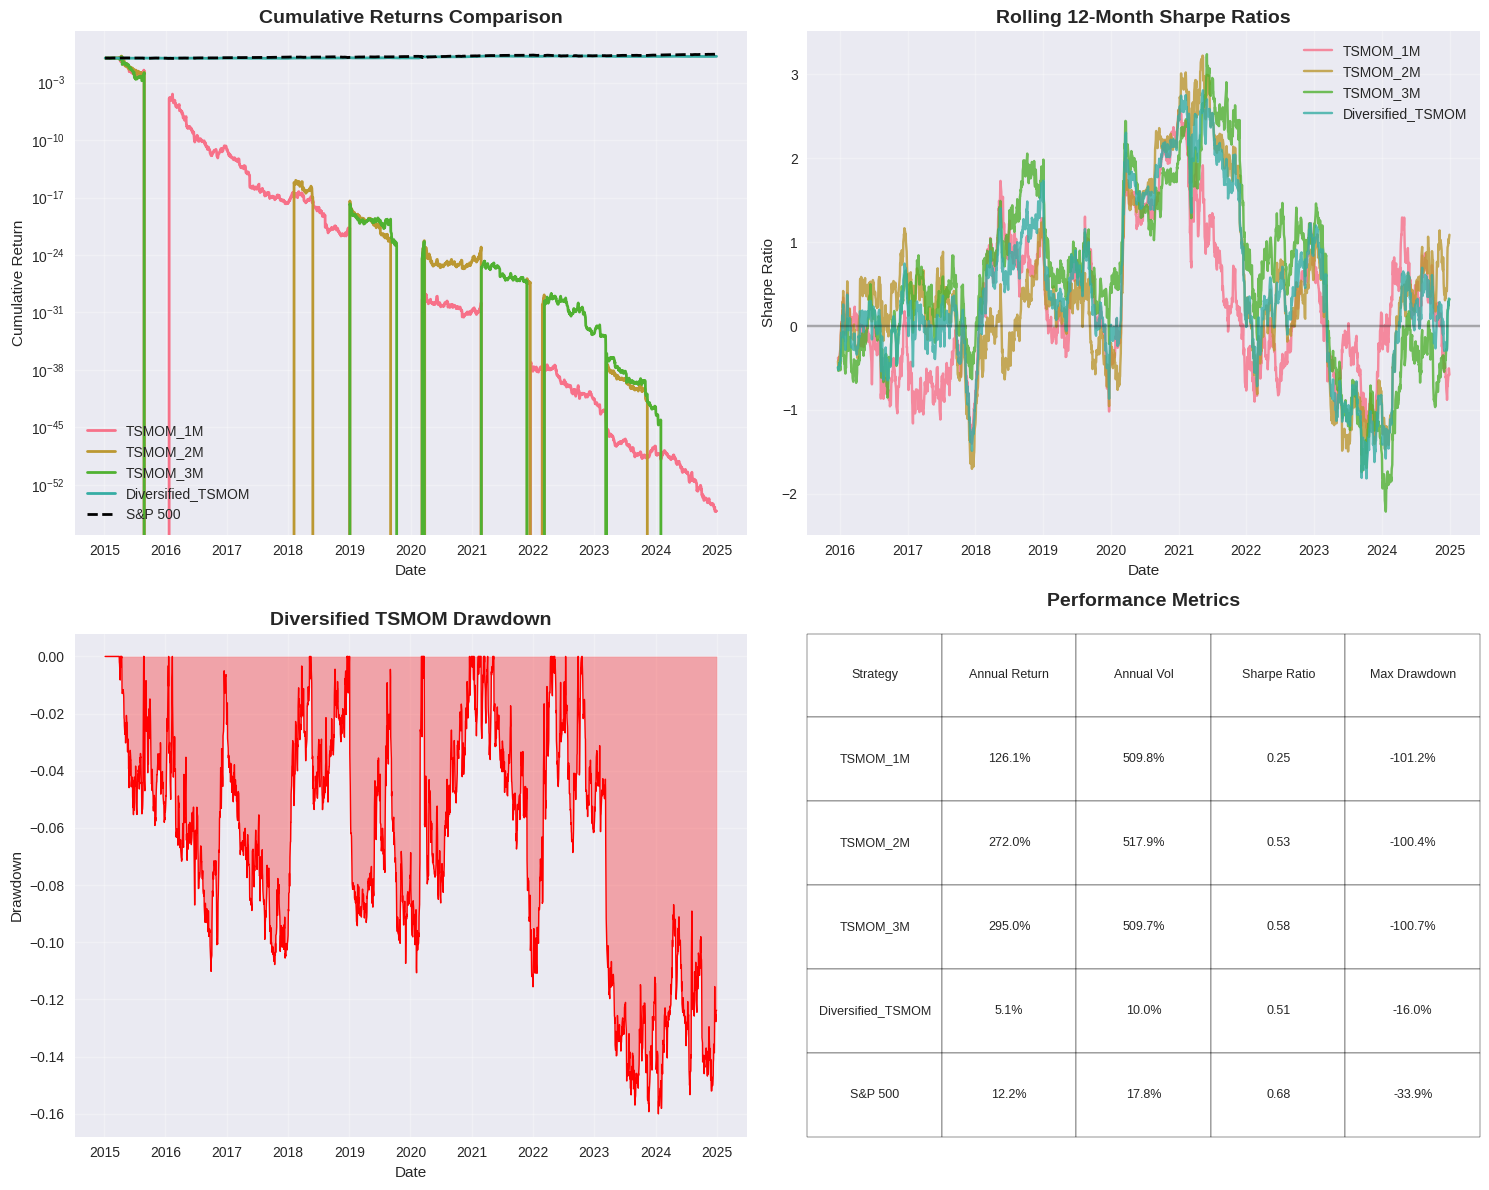

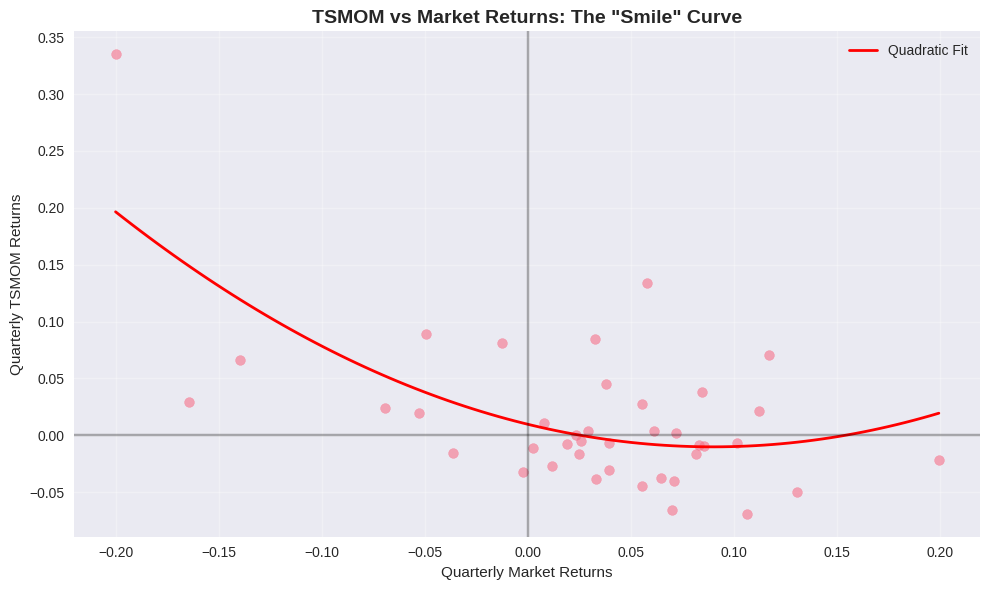


=== Strategy Implementation Complete ===
Note: This is a demonstration using simulated data.
For live trading, use real futures price data and consider:
- Transaction costs (1-4% annually)
- Management fees (typically 2% + 20% performance fee)
- Margin requirements (8-12% for institutional investors)
- Risk management procedures
- Rebalancing frequency optimization


In [24]:
# Main execution
if __name__ == "__main__":
    print("=== Time Series Momentum (TSMOM) Strategy Implementation ===")
    print("Based on 'A Century of Evidence on Trend-Following Investing' by Hurst et al.")
    print()

    # Create data
    prices_df, sp500_prices, rf_rate, metadata = run_full_data_fetch()

    print(f"Data period: {prices_df.index[0].strftime('%Y-%m-%d')} to {prices_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Number of assets: {len(prices_df.columns)}")
    print(f"Assets: {list(prices_df.columns)}")
    print()

    # Initialize and run TSMOM strategy
    tsmom = TSMOMStrategy(lookback_periods=[1, 2, 3], target_vol=0.40, portfolio_vol=0.10)

    print("Running TSMOM strategy...")
    results = tsmom.run_strategy(prices_df, risk_free_rate=0.02)

    # Display performance metrics
    print("\n=== Performance Summary ===")
    for name, returns in results['individual_strategies'].items():
        metrics = calculate_performance_metrics(returns)
        print(f"\n{name}:")
        print(f"  Annual Return: {metrics.get('Annual Return', 0):.1%}")
        print(f"  Annual Volatility: {metrics.get('Annual Volatility', 0):.1%}")
        print(f"  Sharpe Ratio: {metrics.get('Sharpe Ratio', 0):.2f}")
        print(f"  Max Drawdown: {metrics.get('Max Drawdown', 0):.1%}")

    # Plot results
    print("\nGenerating performance charts...")
    sp500_returns = sp500_prices.pct_change().dropna()

    plot_performance_comparison(results, sp500_prices)
    plot_smile_curve(results['diversified_returns'], sp500_returns)

    print("\n=== Strategy Implementation Complete ===")
    print("Note: This is a demonstration using simulated data.")
    print("For live trading, use real futures price data and consider:")
    print("- Transaction costs (1-4% annually)")
    print("- Management fees (typically 2% + 20% performance fee)")
    print("- Margin requirements (8-12% for institutional investors)")
    print("- Risk management procedures")
    print("- Rebalancing frequency optimization")